In [1]:
import warnings
warnings.filterwarnings('ignore') # For better visibility, warnings are turned off in this notebook

# FINE Webinar Part I: 2-nodal Electricity Supply System

In this application of the FINE framework, an energy supply system, consisting of two-regions, is modeled and optimized.

The workflow is structures as follows:
-  Required packages are imported
-  An energy system model instance is created
-  Commodity sources are added to the energy supply system model
-  Commodity conversion components are added to the energy supply system model
-  Commodity storages are added to the energy supply system model
-  Commodity transmission components are added to the energy supply system model
-  Commodity sinks are added to the energy supply system model
-  The energy supply system model is optimized
-  Selected optimization results are presented

# Import required packages

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [2]:
import FINE as fn         # Provides objects and functions to model an energy system 
import pandas as pd       # Used to manage data in tables
import shapely as shp     # Used to generate geometric objects
import numpy as np        # Used to generate random input data
np.random.seed(42)        # Sets a "seed" to produce the same random input data in each model run

In [ ]:
import geopandas as gpd   # Used to display geo-referenced plots

# Model an energy system

## Create an energy system model instance 

The structure of the energy supply system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_naturalGas_lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [3]:
# Input parameters
locations = {'regionN', 'regionS'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'naturalGas': r'GW$_{CH_{4},LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h'}
commodities = {'electricity', 'naturalGas', 'CO2'}
numberOfTimeSteps, hoursPerTimeStep = 8760, 1
costUnit, lengthUnit = '1e6 Euro', 'km'

# Code
esM = fn.EnergySystemModel(locations=locations, commodities=commodities,
    numberOfTimeSteps=numberOfTimeSteps, commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=hoursPerTimeStep, costUnit=costUnit, lengthUnit=lengthUnit, verboseLogLevel=0)

## Add source components

Source components generate commodities across the energy system's virtual boundaries.

In [4]:
# Input parameters
name, commodity ='Wind turbines', 'electricity'
hasCapacityVariable = True
operationRateMax = pd.DataFrame([[np.random.beta(a=2,b=7.5),np.random.beta(a=2,b=9)]
                                  for t in range(8760)],
                                index=range(8760), columns=['regionN', 'regionS']).round(6)
capacityMax = pd.Series([400, 200], index=['regionN', 'regionS'])
investPerCapacity, opexPerCapacity = 1200, 1200*0.02
interestRate, economicLifetime = 0.08, 20

# If data should be read from an excel file:
writer = pd.ExcelWriter('windTurbineProfile.xlsx') # writes data to an excel file
operationRateMax.to_excel(writer)                  # (not required if excel file
writer.save()                                      #  already exists)
operationRateMax = pd.read_excel('windTurbineProfile.xlsx', index_col=0) # reads an excel file located in 
                                                            # the current working directory
    
# Code
esM.add(fn.Source(esM=esM, name=name, commodity=commodity, hasCapacityVariable=hasCapacityVariable,
    operationRateMax=operationRateMax, capacityMax=capacityMax, investPerCapacity=investPerCapacity,
    opexPerCapacity=opexPerCapacity, interestRate=interestRate, economicLifetime=economicLifetime))

In [5]:
# Input parameters
name, commodity ='PV', 'electricity'
hasCapacityVariable = True
dailyProfileSimple = [0,0,0,0,0,0,0,0.05,0.15,0.2,0.4,0.8,0.7,0.4,0.2,0.15,0.05,0,0,0,0,0,0,0]
operationRateMax = pd.DataFrame([[u,u] for day in range(365) for u in dailyProfileSimple],
                                index=range(8760), columns=['regionN', 'regionS'])
capacityMax = pd.Series([100, 100], index=['regionN', 'regionS'])
investPerCapacity, opexPerCapacity = 800, 800*0.02
interestRate, economicLifetime = 0.08, 25

# If data should be read from an excel file:
writer = pd.ExcelWriter('PV_Profile.xlsx') # writes data to an excel file
operationRateMax.to_excel(writer)                  # (not required if excel file
writer.save()                                      #  already exists)
operationRateMax = pd.read_excel('PV_Profile.xlsx', index_col=0) # reads an excel file located in 
                                                            # the current working directory

# Code
esM.add(fn.Source(esM=esM, name=name, commodity=commodity, hasCapacityVariable=hasCapacityVariable,
    operationRateMax=operationRateMax, capacityMax=capacityMax, investPerCapacity=investPerCapacity,
    opexPerCapacity=opexPerCapacity, interestRate=interestRate, economicLifetime=economicLifetime))

In [6]:
# Input parameters
name, commodity ='Natural gas import', 'naturalGas'
hasCapacityVariable = False
commodityCost = 0.03

# Code
esM.add(fn.Source(esM=esM, name=name, commodity=commodity, hasCapacityVariable=hasCapacityVariable,
    commodityCost=commodityCost))

##  Add conversion components

Conversion components convert m commodities into n other commodities.

In [7]:
# Input parameters
name, physicalUnit = 'Gas power plants', r'GW$_{el}$'
commodityConversionFactors = {'electricity':1, 'naturalGas':-1/0.63, 'CO2':201*1e-6/0.63}
hasCapacityVariable=True
investPerCapacity, opexPerCapacity = 650, 650*0.03
interestRate, economicLifetime = 0.08, 30

# Code
esM.add(fn.Conversion(esM=esM, name=name, physicalUnit=physicalUnit,
    commodityConversionFactors=commodityConversionFactors, hasCapacityVariable=hasCapacityVariable,
    investPerCapacity=investPerCapacity, opexPerCapacity=opexPerCapacity, 
    interestRate=interestRate, economicLifetime=economicLifetime))

## Add storage components

Storage components can store commodities across time steps.

The self discharge of a storage technology is described in FINE in percent per hour. If the literature value is given in percent per month, e.g. 3%/month, the self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [8]:
# Input parameters
name, commodity = 'Batteries', 'electricity'
hasCapacityVariable=True
chargeEfficiency, dischargeEfficiency, selfDischarge = 0.95, 0.95, 1-(1-0.03)**(1/(30*24))
chargeRate, dischargeRate = 1, 1
investPerCapacity, opexPerCapacity = 150, 150*0.01
interestRate, economicLifetime, cyclicLifetime = 0.08, 22, 12000

# Code
esM.add(fn.Storage(esM=esM, name=name, commodity=commodity, hasCapacityVariable=hasCapacityVariable,
    chargeEfficiency=chargeEfficiency, cyclicLifetime=cyclicLifetime,
    dischargeEfficiency=dischargeEfficiency, selfDischarge=selfDischarge, chargeRate=chargeRate,
    dischargeRate=dischargeRate, investPerCapacity=investPerCapacity,
    opexPerCapacity=opexPerCapacity, interestRate=interestRate, economicLifetime=economicLifetime))

## Add transmission components

Transmission components transmit commodities between regions.

In [9]:
# Input parameters
name, commodity ='AC cables', 'electricity'
hasCapacityVariable = True
capacityFix = pd.DataFrame([[0, 30], [30, 0]], columns=['regionN', 'regionS'],
    index=['regionN', 'regionS'])
distances = pd.DataFrame([[0, 400], [400, 0]], columns=['regionN', 'regionS'],
    index=['regionN', 'regionS'])
losses=0.0001

# Code
esM.add(fn.Transmission(esM=esM, name=name, commodity=commodity,
    hasCapacityVariable=hasCapacityVariable, capacityFix=capacityFix,
    distances=distances, losses=losses))

In [10]:
distances

,regionN,regionS
regionN,0,400
regionS,400,0


## Add sink components

Sinks remove commodities across the energy system´s virtual boundaries.

In [11]:
# Input parameters
name, commodity ='Electricity demand', 'electricity',
hasCapacityVariable = False
dailyProfileSimple = [0.6,0.6,0.6,0.6,0.6,0.7,0.9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.9,0.8]
operationRateFix = pd.DataFrame([[(u+0.1*np.random.rand())*25,(u+0.1*np.random.rand())*40]
                                 for day in range(365) for u in dailyProfileSimple],
                                index=range(8760), columns=['regionN', 'regionS']).round(2)

# If data should be read from an excel file:
writer = pd.ExcelWriter('demandProfile.xlsx') # writes data to an excel file
operationRateFix.to_excel(writer)                  # (not required if excel file
writer.save()                                      #  already exists)
operationRateFix = pd.read_excel('demandProfile.xlsx', index_col=0) # reads an excel file located in 
                                                            # the current working directory

# Code
esM.add(fn.Sink(esM=esM, name=name, commodity=commodity, hasCapacityVariable=hasCapacityVariable,
    operationRateFix=operationRateFix))

In [12]:
# Input parameters
name, commodity ='CO2 to enviroment', 'CO2',
hasCapacityVariable=False
commodityLimitID, yearlyLimit ='CO2 limit', 366*(1-0.8)

# Code
if yearlyLimit > 0:
    esM.add(fn.Sink(esM=esM, name=name, commodity=commodity,
        hasCapacityVariable=hasCapacityVariable, commodityLimitID=commodityLimitID,
        yearlyLimit=yearlyLimit))

# Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [13]:
# Input parameters
numberOfTypicalPeriods=30

# Code
esM.cluster(numberOfTypicalPeriods=numberOfTypicalPeriods)


Clustering time series data with 30 typical periods and 24 time steps per period...
		(0.4040 sec)



 C:\Users\k.knosala\Miniconda3\envs\fine-dev-py36\lib\site-packages\tsam\timeseriesaggregation.py:982: UserWarning:Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series


In [14]:
# Input parameters
timeSeriesAggregation=True
solver='glpk'

# Code
esM.optimize(timeSeriesAggregation=timeSeriesAggregation, solver=solver)

Time series aggregation specifications:
Number of typical periods:30, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3064 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0380 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3395 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1054 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.2520 sec)

Declaring objective function...
		(0.1121 sec)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line

# Output of selected results

For the assessment of the optimization result, several result output functions are available. They can be categorized into output in form of tables, geo-referenced output visualization and the full time series visualization.


## Create a regional shape file and visualize it

Information on the geometrical shape of the investigated regions can either be downloaded from a website (e.g. from https://gadm.org/) or manually created. In this notebook, the geometries are manually created.

 c:\users\k.knosala\tools\fine\FINE\IOManagement\standardIO.py:658: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\k.knosala\tools\fine\FINE\IOManagement\standardIO.py:658: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


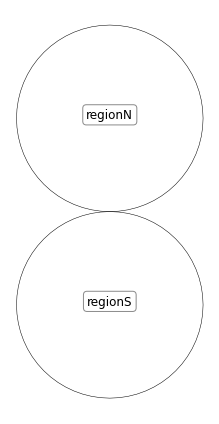

In [15]:
# Create two circles, representing the two regions, and store their geometries in a shape file
shpRegionS = shp.geometry.Point(0.5,0.5).buffer(0.5)
shpRegionN = shp.geometry.Point(0.5,1.5).buffer(0.5)
regionsGdf = gpd.GeoDataFrame({'geometry':[shpRegionN,shpRegionS],
                               'regionName':['regionN','regionS']},
                              index=['regionN','regionS'], crs='epsg:3035')
regionsGdf.to_file('regions.shp')

# Create a line, representing the connection between the two regions, and store its geometry in a
# shape file
lines = shp.geometry.LineString([(0.5,0.5),(0.5,1.5)])
linesGdf = gpd.GeoDataFrame({'geometry':[lines, lines],'loc0':['regionN','regionS'],
                             'loc1':['regionS','regionN']},
                            index=['regionN_regionS','regionS_regionN'], crs='epsg:3035')
linesGdf.to_file('lines.shp')

# Visualize the geometric representation of the two regions
fig, ax = fn.plotLocations('regions.shp', indexColumn='regionName', plotLocNames=True)

## Display optimization summaries

For each modeling class, an optimization summary can be stored and displayed. 

In [16]:
srcSnkSummary = esM.getOptimizationSummary("SourceSinkModel", outputLevel=1)
display(esM.getOptimizationSummary("SourceSinkModel", outputLevel=2))

regionN  regionS
Component          Property    Unit                                     
CO2 to enviroment  operation   [Mio. t$_{CO_2}$/h*h/a]  2.86345  70.3366
                               [Mio. t$_{CO_2}$/h*h]    2.86345  70.3366
Electricity demand operation   [GW$_{el}$*h/a]           205208   328596
                               [GW$_{el}$*h]             205208   328596
Natural gas import TAC         [1e6 Euro/a]             427.381    10498
                   commodCosts [1e6 Euro/a]             427.381    10498
                   operation   [GW$_{CH_{4},LHV}$*h/a]    14246   349933
                               [GW$_{CH_{4},LHV}$*h]      14246   349933
PV                 TAC         [1e6 Euro/a]                   0  2635.28
                   capacity    [GW$_{el}$]                    0  28.9772
                   capexCap    [1e6 Euro/a]                   0  2171.64
                   invest      [1e6 Euro]                     0  23181.8
                   operation   [GW$_{el}$*h/a]                0  32787.7
                               [GW$_{el}$*h]                  0  32787.7
                   opexCap     [1e6 Euro/a]                   0  463.636
Wind turbines      TAC         [1e6 Euro/a]             22022.8        0
                   capacity    [GW$_{el}$]              150.611        0
                   capexCap    [1e6 Euro/a]             18408.1        0
                   invest      [1e6 Euro]                180734        0
                   operation   [GW$_{el}$*h/a]           277569        0
                               [GW$_{el}$*h]             277569        0
                   opexCap     [1e6 Euro/a]             3614.68        0

In [17]:
convSummary = esM.getOptimizationSummary("ConversionModel", outputLevel=1)
display(esM.getOptimizationSummary("ConversionModel", outputLevel=2))

regionN  regionS
Component        Property  Unit                             
Gas power plants TAC       [1e6 Euro/a]     220.614  3139.39
                 capacity  [GW$_{el}$]      2.85629  40.6457
                 capexCap  [1e6 Euro/a]     164.916   2346.8
                 invest    [1e6 Euro]       1856.59  26419.7
                 operation [GW$_{el}$*h/a]  8974.99   220458
                           [GW$_{el}$*h]    8974.99   220458
                 opexCap   [1e6 Euro/a]     55.6977  792.591

In [18]:
storSummary = esM.getOptimizationSummary("StorageModel", outputLevel=1)
display(esM.getOptimizationSummary("StorageModel", outputLevel=2))

regionN  regionS
Component Property           Unit                             
Batteries TAC                [1e6 Euro/a]     825.344  59.9289
          capacity           [GW$_{el}$*h]     50.932  3.69822
          capexCap           [1e6 Euro/a]     748.946  54.3816
          invest             [1e6 Euro]        7639.8  554.733
          operationCharge    [GW$_{el}$*h/a]  22331.1  853.585
                             [GW$_{el}$*h]    22331.1  853.585
          operationDischarge [GW$_{el}$*h/a]  20147.4  770.094
                             [GW$_{el}$*h]    20147.4  770.094
          opexCap            [1e6 Euro/a]      76.398  5.54733

In [19]:
transSummary = esM.getOptimizationSummary("TransmissionModel", outputLevel=1)
display(esM.getOptimizationSummary("TransmissionModel", outputLevel=2))

regionN  regionS
Component Property  Unit            LocationIn                  
AC cables capacity  [GW$_{el}$]     regionN         NaN       30
                                    regionS          30      NaN
          operation [GW$_{el}$*h/a] regionN         NaN  85913.4
                                    regionS     7042.58      NaN
                    [GW$_{el}$*h]   regionN         NaN  85913.4
                                    regionS     7042.58      NaN

## Display regional and operational plots

Georeferenced plots as well as plots representing time series can be displayed for each component.

### Wind turbines

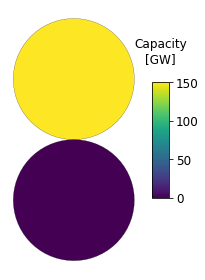

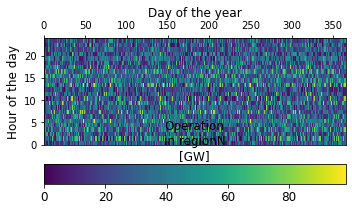

In [20]:
# If wind turbines are built, their capacities are displayed in a geo-referenced plot
if srcSnkSummary.loc[('Wind turbines','capacity','[GW$_{el}$]')].sum() > 0:
    fig, ax = fn.plotLocationalColorMap(esM, 'Wind turbines', 'regions.shp', 'regionName',
        perArea=False, zlabel='Capacity\n[GW]\n', figsize=(4,4))
else:
    print('No wind turbines built.')

# If wind turbines are built in regionN, their operation is displayed as heatmap
if srcSnkSummary.loc[('Wind turbines','capacity','[GW$_{el}$]'),'regionN'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Wind turbines', 'regionN', figsize=(5,3), 
        xlabel='Day of the year', ylabel='Hour of the day', zlabel='Operation\nin regionN\n[GW]')

# If wind turbines are built in regionS, their operation is displayed as heatmap
if srcSnkSummary.loc[('Wind turbines','capacity','[GW$_{el}$]'),'regionS'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Wind turbines', 'regionS', figsize=(5,3), 
        xlabel='Day of the year', ylabel='Hour of the Day', zlabel='Operation\nin regionS\n[GW]', orientation='vertical')

### PV systems

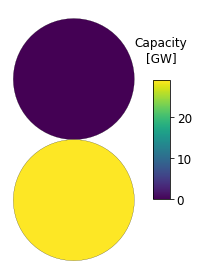

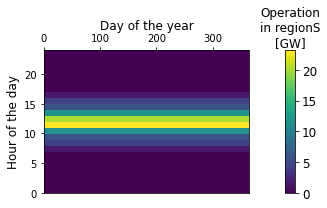

In [21]:
# If PV systems are built, their capacities are displayed in a geo-referenced plot
if srcSnkSummary.loc[('PV','capacity','[GW$_{el}$]')].sum() > 0:
    fig, ax = fn.plotLocationalColorMap(esM, 'PV', 'regions.shp', 'regionName', perArea=False,
        zlabel='Capacity\n[GW]\n', figsize=(4,4))
else:
    print('No PV systems built.')

# If PV systems are built in regionS, their operation is displayed as heatmap
if srcSnkSummary.loc[('PV','capacity','[GW$_{el}$]'),'regionN'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'PV', 'regionN', figsize=(5,3), 
        xlabel='Day of the year', ylabel='Hour of the day', zlabel='Operation\nin regionN\n[GW]')

# If PV systems are built in regionS, their operation is displayed as heatmap
if srcSnkSummary.loc[('PV','capacity','[GW$_{el}$]'),'regionS'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'PV', 'regionS', figsize=(5,3), 
        xlabel='Day of the year', ylabel='Hour of the day', zlabel='Operation\nin regionS\n[GW]', orientation='vertical')

### Gas power plants

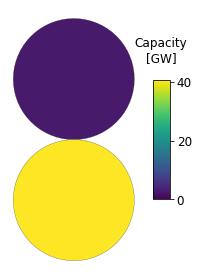

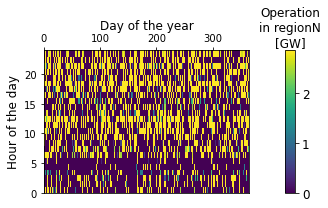

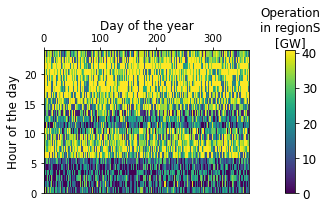

In [22]:
# If CCGT plants are built, their capacities are displayed in a geo-referenced plot
if convSummary.loc[('Gas power plants','capacity','[GW$_{el}$]')].sum() > 0:
    fig, ax = fn.plotLocationalColorMap(esM, 'Gas power plants', 'regions.shp', 'regionName',
        perArea=False, zlabel='Capacity\n[GW]\n', figsize=(4,4))
else:
    print('No CCGT plants built.')

# If CCGT plants are built in regionS, their operation is displayed as heatmap
if convSummary.loc[('Gas power plants','capacity','[GW$_{el}$]'),'regionN'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Gas power plants', 'regionN', figsize=(5,3), 
        xlabel='Day of the year', ylabel='Hour of the day', zlabel='Operation\nin regionN\n[GW]', orientation='vertical')

# If CCGT plants are built in regionS, their operation is displayed as heatmap
if convSummary.loc[('Gas power plants','capacity','[GW$_{el}$]'),'regionS'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Gas power plants', 'regionS', figsize=(5,3), 
        xlabel='Day of the year', ylabel='Hour of the day', zlabel='Operation\nin regionS\n[GW]', orientation='vertical')

### Batteries

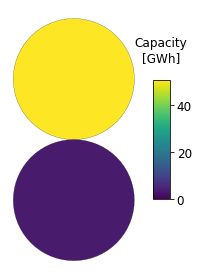

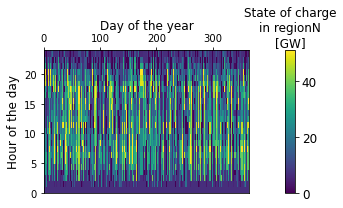

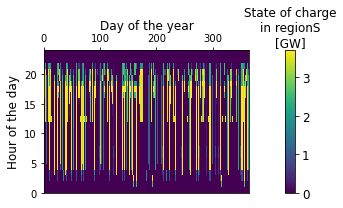

In [23]:
# If batteries are built, their capacities are displayed in a geo-referenced plot
if storSummary.loc[('Batteries','capacity','[GW$_{el}$*h]')].sum() > 0:
    fig, ax = fn.plotLocationalColorMap(esM, 'Batteries', 'regions.shp', 'regionName',
        perArea=False, zlabel='Capacity\n[GWh]\n', figsize=(4,4))
else:
    print('No batteries built.')
    
# If batteries are built in regionS, their storage inventory is displayed as heatmap
if storSummary.loc[('Batteries','capacity','[GW$_{el}$*h]'),'regionN'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Batteries', 'regionN', figsize=(5,3),
        xlabel='Day of the year', ylabel='Hour of the day',
        zlabel='State of charge\nin regionN\n[GW]',
        variableName='stateOfChargeOperationVariablesOptimum', orientation='vertical')

# If batteries are built in regionS, their storage inventory is displayed as heatmap
if storSummary.loc[('Batteries','capacity','[GW$_{el}$*h]'),'regionS'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Batteries', 'regionS', figsize=(5,3),
        xlabel='Day of the year', ylabel='Hour of the day',
        zlabel='State of charge\nin regionS\n[GW]',
        variableName='stateOfChargeOperationVariablesOptimum', orientation='vertical')

### AC cables

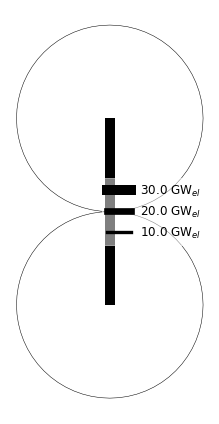

In [24]:
# The built AC cable capacities are displayed
fig, ax = fn.plotLocations('regions.shp', indexColumn='regionName')   
fig, ax = fn.plotTransmission(esM, 'AC cables', 'lines.shp', loc0='loc0', loc1='loc1',
    fig=fig, ax=ax, cbHeight=0.4)

### Electricity demand

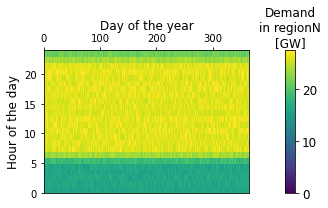

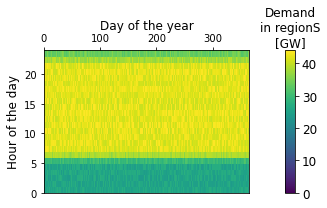

In [25]:
# The electricity demand time series in regionN is displayed
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'regionN', figsize=(5,3), 
    xlabel='Day of the year', ylabel='Hour of the day', zlabel='Demand\nin regionN\n[GW]', orientation='vertical')

# The electricity demand time series in regionS is displayed
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'regionS', figsize=(5,3), 
    xlabel='Day of the year', ylabel='Hour of the day', zlabel='Demand\nin regionS\n[GW]', orientation='vertical')